In [5]:
# Canopy Lauyer Function
# Scratch file for testing out parameterization and spline fitting
# 11/7/22
# PB

import laspy
import pdal
import json
import geopandas as gpd
import numpy as np
from pathlib import Path
from shapely.geometry import Polygon
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import pickle

In [26]:
# Testing whether working with the cover profile
# is better

# Input Data:

# Radius of shapefile to use
radius = 30

# Set the pickle metrics to draw from
metricdir = Path(f'/n/davies_lab/Users/pbb/SelenkayDiversity/data/out/Metrics/{radius}mRadius/')

# Horizontal Grid size
xysize = 0.5

# Ground threshold
groundthreshold = 0.05

# Set CRS
# Selenkay is 32737 (WGS84 UTM37S)
epsg='32737'

site = '3a'

# Load Cover percentile dict
with open(f'{metricdir}/{site}_{xysize}mgrid_covermetrics.obj', 'rb') as of:
    cover = pickle.load(of)
    
with open(f'{metricdir}/{site}_{xysize}mgrid_heights.obj', 'rb') as of:
    heights = pickle.load(of)
    

In [27]:
c = cover[(313092.68, 9737807.49)]
h = heights[(313092.68, 9737807.49)]

In [35]:
hbins = c['HeightBins'][:-1]

hcounts_norm = c['CoverD2byH']

# Interpolate heights and derivative to 1 cm increments so that you have more precise inflection points
hbins_interp= np.arange(np.min(hbins), np.max(hbins), 0.01)

# smooth with gaussian filter
gauss1d = gaussian_filter1d(c['CoverD2byH'], 0.5)

# interpolate with hbins_interp to make it more dense
smooth = np.interp(x=hbins_interp, xp=hbins, fp=gauss1d)

In [29]:
# Find Peaks and troughs
idx_peaks, meta = find_peaks(smooth)

# Get the widths of the peak and identify the troughs using a relative heiht value
# rel_height = 0.5 is the full width half max
# rel_height = 1 is the bottom of the gaussian
w, width_heights, left_ips, right_ips = peak_widths(smooth, idx_peaks, rel_height=1)

# NOTE: convert peak and trough indices back to height values using the below function
# copied exactly from: https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

widths = index_to_xdata(hbins_interp, w)
left_ips = index_to_xdata(hbins_interp, left_ips)
right_ips = index_to_xdata(hbins_interp, right_ips)

troughs = np.append(left_ips, right_ips)
peaks = hbins_interp[idx_peaks]

# Number of layers as number of peaks
nlayers = len(peaks)


(0.0, 14.8)

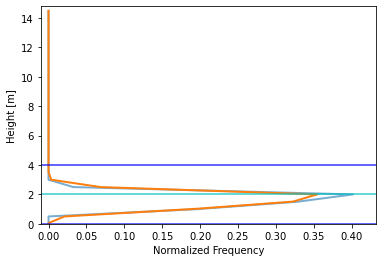

In [30]:
 fig, ax = plt.subplots()
                
pd = ax.plot(hcounts_norm, hbins, label='Point Density', lw=2, alpha=0.6)

s = ax.plot(smooth, hbins_interp, lw=2)

for infl in troughs:
    tline = ax.axhline(y=infl, color='b', label='Trough', alpha=0.8)
for infl in peaks:
    pline = ax.axhline(y=infl, color='c', label='Peak', alpha=0.8)

# ax.legend(handles=[s, pd, tline, pline], loc='best')
# ax.legend(loc='best')
ax.set_xlabel('Normalized Frequency')
ax.set_ylabel('Height [m]')
ax.set_xlim(-0.01, np.max(hcounts_norm) + 0.03)
ax.set_ylim(0, np.max(hbins) + 0.3)


({'nlayers': 1,
  'gapsize': 0,
  'maxpeakh': 2.5,
  'ptoh': 0.9803921751955851,
  'cscore': 0.12903225806451613,
  'FHD': 1.1674772126808877,
  'VDR': 0.2458823,
  'VDRpeak': 0,
  'meanpeakh': 2.5,
  'stdpeakh': 0,
  'cvpeakh': 0},
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized Frequency', ylabel='Height [m]'>)

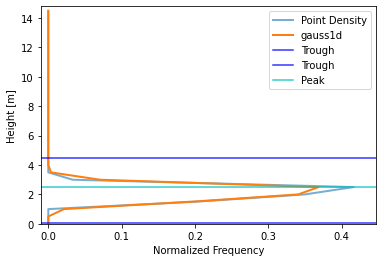

In [33]:
canopyLayerMetrics(h, hbins, plot=True, method='gauss1d', smoothsigma=0.5, rel_height=1)

In [44]:
def canopyLayerMetrics(h, hbins, plot=False, smoothsigma=2, method='gauss1d', rel_height=0.75, groundthreshold=0.05):
    # Where h is an array of point height values
    # hbins is a list/array of height bin edges
    # smoothsigma = positive float - gives a smoothing parameter for gaussian smoothing in layer calculation (in meters)
    # plot = True/False - whether to plot the results
    # method = ['gauss1d'] with smoothsigma = 2 (default)
    # method = ['kde'] with rule-of-thumb approximation of sigma
    # relH_peakwidth = 0.75 - rel. height of peak to find the "trough" bottoms at
        # rel_height = 0.5 is the full width half max
        # rel_height = 1 is the bottom of the gaussian
    
    # If there are any heights in the array
    # edited 10/26 - have to have at least 2 points above the ground to do complexity stats
    # This means that a plot with only 1 point will have all metrics automatically set to 0 or nan
    if np.sum(np.array(h) > 0) >= 2:

        # sort points by height
        h = np.sort(h)
        
        # Interpolate heights and derivative to 1 cm increments so that you have more precise inflection points
        hbins_interp= np.arange(np.min(hbins), np.max(hbins), 0.01)
        
        # Group each point by height bin
        hgroups = np.digitize(h, bins=hbins)

        # Count the number of points in each bin
        # Note: minlength allows it to go to the full length of hbins, rather than stop at the max height of the points
        hcounts = np.bincount(hgroups, minlength=len(hbins))

        # Normalize the counts
        hcounts_norm = hcounts/np.sum(hcounts)
        
        # If using a gaussian kernel density estimate from the height array
        if method == 'kde':

            gausskde = gaussian_kde(h, bw_method='scott')
            smooth = gausskde.pdf(hbins_interp)

        # else, if using a smoothed version of point density by height
        else:
            
            # smooth with gaussian filter
            gauss1d = gaussian_filter1d(hcounts_norm, smoothsigma)
            
            # interpolate with hbins_interp to make it more dense
            smooth = np.interp(x=hbins_interp, xp=hbins, fp=gauss1d)
            
        # Find Peaks and troughs
        idx_peaks, meta = find_peaks(smooth)

        # Get the widths of the peak and identify the troughs using a relative heiht value
        # rel_height = 0.5 is the full width half max
        # rel_height = 1 is the bottom of the gaussian
        w, width_heights, l_ips, r_ips = peak_widths(smooth, idx_peaks, rel_height=rel_height)

        # NOTE: convert peak and trough indices back to height values using the below function
        # copied exactly from: https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
        def index_to_xdata(xdata, indices):
            "interpolate the values from signal.peak_widths to xdata"
            ind = np.arange(len(xdata))
            f = interp1d(ind,xdata)
            return f(indices)

        # get heights of troughs
        widths = index_to_xdata(hbins_interp, w)
        left_ips = index_to_xdata(hbins_interp, l_ips)
        right_ips = index_to_xdata(hbins_interp, r_ips)
        troughs = np.append(left_ips, right_ips)
        
        # get density of troughs for plotting
        smooth_left_ips = index_to_xdata(smooth, l_ips)
        smooth_right_ips = index_to_xdata(smooth, r_ips)
        smooth_troughs = np.append(smooth_left_ips, smooth_right_ips)
        
        # Get heights of peaks
        peaks = hbins_interp[idx_peaks]

        # Number of layers as number of peaks
        nlayers = len(peaks)

        if nlayers > 1:

            # height location of peak with largest frequency of points
            # maxpeakh = peaks[np.argmax(smooth[idx_peaks])]
            maxpeakh = np.nanmax(peaks)

            # Get the gap size as the maximum distance between consecutive peaks
            gapsize = np.max(np.diff(peaks))

            # MEAN and STD peak HEIGHT
            # made up by peter
            meanpeakh = np.nanmean(peaks)
            stdpeakh = np.nanstd(peaks)
            cvpeakh = np.nanmean(peaks)/np.nanstd(peaks)

            # Vertical Distribution Ratio (Goetz 2007) 
            # - experimental, computed from peaks instead of norm point distribution
            VDRpeak = (np.max(peaks) - np.nanmedian(peaks)) / np.max(peaks)
            
            # get the top of the herbaceous layer from the troughs
            # New addition 11/9/22
            # The herbaceous height is the 2nd trough up from the bottom
            # but it has to be higher than the groundthreshold
            # otherwise, we set the herb height to be 0
            # this means you can't detect a herbaceous layer lower than the groundthreshold (usallually 5 cm)
            herbtroughs = troughs[troughs >= groundthreshold]
            if herbtroughs.size:
                herbh = np.sort(herbtroughs)[0]
            else:
                herbh = 0
            
        else:

            # Edited 10/31/22 
            # If there's only 1 layer, 
            # set the peaks to be the only peak height
            if peaks.size:
                maxpeakh = peaks[0]
                meanpeakh = peaks[0]
                
                # New addition 11/9/22
                # The herbaceous height is the 2nd trough up from the bottom
                # but it has to be higher than the groundthreshold
                # otherwise, we set the herb height to be 0
                # this means you can't detect a herbaceous layer lower than the groundthreshold (usallually 5 cm)
                herbtroughs = troughs[troughs >= groundthreshold]
                if herbtroughs.size:
                    herbh = np.sort(herbtroughs)[0]
                else:
                    herbh = 0
                    
            # Except if there is no peak to record
            else:
                maxpeakh = 0
                meanpeakh = 0 
                herbh = 0

            # and variation metrics to 0
            stdpeakh = 0
            gapsize = 0
            cvpeakh = 0
            VDRpeak = 0
        
        # computing the PtoH ratio (Davies 2020, Asner 2014)
        perc99 = np.nanpercentile(h, 99, method='median_unbiased')
        ptoh = maxpeakh/perc99

        # Complexity Score (Davies 2020)
        # proportion of bins with points in them vs without
        # could be insensitive to striping
        cscore = np.sum(hcounts>0)/len(hcounts)

        # Vertical Distribution Ratio (Goetz 2007)
        VDR = (np.max(h) - np.median(h)) / np.max(h)
        
        # Foliage Height Diversity 
        # (Bergen 2009 and many others using PAI profile - this is using normalized point counts)
        if np.sum(hcounts_norm>0) > 0:
            FHD = -1*np.sum(hcounts_norm*np.log(hcounts_norm, where=hcounts_norm>0))
        else:
            FHD = 0

        ### SAVE Outputs
        complex_dict = {'nlayers':nlayers,
                        'gapsize':gapsize,
                        'maxpeakh':maxpeakh,
                        'ptoh':ptoh,
                        'cscore':cscore,
                        'FHD':FHD,
                        'VDR':VDR,
                        'VDRpeak':VDRpeak,
                        'meanpeakh':meanpeakh,
                        'stdpeakh':stdpeakh,
                        'cvpeakh':cvpeakh,
                        'herbh':herbh
                       }

        if plot:

            fig, ax = plt.subplots()
                
            ax.plot(hcounts_norm, hbins, label='Point Density', lw=5, c='k', alpha=0.6)
                
            ax.plot(smooth, hbins_interp, label=method, lw=3, c='c', alpha=0.9, linestyle='--')
            
            ax.axhline(y=herbh, color='olive', label=f'Herb. Height {np.round(herbh, 2)}m', alpha=0.8)
                                    
            ax.scatter(x=smooth[idx_peaks], y=hbins_interp[idx_peaks],
                       c='b', label='Peaks', marker='x', linewidths=4)
            
            ax.scatter(x=smooth_troughs, y=troughs,
                      c='r', label='Troughs', marker='x', linewidths=4)
            
            # for infl in troughs:
            #     tline = ax.axhline(y=infl, color='b', label='Trough', alpha=0.8)
            # for infl in peaks:
            #     pline = ax.axhline(y=infl, color='c', label='Peak', alpha=0.8)
            # ax.legend(handles=[tline, pline], loc='best')
            
            ax.legend(loc='best')
            ax.set_xlabel('Normalized Frequency')
            ax.set_ylabel('Height [m]')
            ax.set_xlim(-0.01, np.max(hcounts_norm) + 0.03)
            ax.set_ylim(0, np.percentile(hbins, 50) + 1)
            ax.grid('on')

            # don't return peaks, troughs
            return complex_dict, fig, ax

        else:

            return complex_dict

    # Else, if there were no heights in the array
    # just return an array of 0s
    else:

        complex_dict = {'nlayers':0,
                        'gapsize':0,
                        'maxpeakh':0,
                        'ptoh':0,
                        'cscore':0,
                        'FHD':0,
                        'VDR':0,
                        'VDRpeak':0,
                        'meanpeakh':0,
                        'stdpeakh':0,
                        'cvpeakh':0,
                        'herbh':0
                       }

        return complex_dict


In [59]:
# Complexity Function using cover
# PB 11/23/22
# NOTE: If performing over a set of pixels, need to wrap the below in a loop
def canopyLayerMetrics_cover(cover_dict, h, plot=False, smoothsigma=0.5, method='gauss1d', rel_height=1):
    # smoothsigma = positive float - gives a smoothing parameter for gaussian smoothing in layer calculation (in meters)
    # plot = True/False - whether to plot the results
    # method = ['gauss1d'] with smoothsigma = 2 (default)
    # method = ['kde'] with rule-of-thumb approximation of sigma
    # relH_peakwidth = 0.75 - rel. height of peak to find the "trough" bottoms at
        # rel_height = 0.5 is the full width half max
        # rel_height = 1 is the bottom of the gaussian
        
    hbins = c['HeightBins'][:-1]

    hcounts_norm = c['CoverD2byH']
    
    if np.any(hcounts_norm >= 0):

        # Interpolate heights and derivative to 1 cm increments so that you have more precise inflection points
        hbins_interp= np.arange(np.min(hbins), np.max(hbins), 0.01)
        
        # If using a gaussian kernel density estimate from the height array
        if method == 'kde':

            gausskde = gaussian_kde(h, bw_method='scott')
            smooth = gausskde.pdf(hbins_interp)

        # else, if using a smoothed version of point density by height
        else:
            
            # smooth with gaussian filter
            gauss1d = gaussian_filter1d(hcounts_norm, smoothsigma)
            
            # interpolate with hbins_interp to make it more dense
            smooth = np.interp(x=hbins_interp, xp=hbins, fp=gauss1d)
            
        # Find Peaks and troughs
        idx_peaks, meta = find_peaks(smooth)

        # Get the widths of the peak and identify the troughs using a relative heiht value
        # rel_height = 0.5 is the full width half max
        # rel_height = 1 is the bottom of the gaussian
        w, width_heights, l_ips, r_ips = peak_widths(smooth, idx_peaks, rel_height=rel_height)

        # NOTE: convert peak and trough indices back to height values using the below function
        # copied exactly from: https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
        def index_to_xdata(xdata, indices):
            "interpolate the values from signal.peak_widths to xdata"
            ind = np.arange(len(xdata))
            f = interp1d(ind,xdata)
            return f(indices)

        # get heights of troughs
        widths = index_to_xdata(hbins_interp, w)
        left_ips = index_to_xdata(hbins_interp, l_ips)
        right_ips = index_to_xdata(hbins_interp, r_ips)
        troughs = np.append(left_ips, right_ips)
        
        # get density of troughs for plotting
        smooth_left_ips = index_to_xdata(smooth, l_ips)
        smooth_right_ips = index_to_xdata(smooth, r_ips)
        smooth_troughs = np.append(smooth_left_ips, smooth_right_ips)
        
        # Get heights of peaks
        peaks = hbins_interp[idx_peaks]

        # Number of layers as number of peaks
        nlayers = len(peaks)

        if nlayers > 1:

            # height location of peak with largest frequency of points
            # maxpeakh = peaks[np.argmax(smooth[idx_peaks])]
            maxpeakh = np.nanmax(peaks)

            # Get the gap size as the maximum distance between consecutive peaks
            gapsize = np.max(np.diff(peaks))

            # MEAN and STD peak HEIGHT
            # made up by peter
            meanpeakh = np.nanmean(peaks)
            stdpeakh = np.nanstd(peaks)
            cvpeakh = np.nanmean(peaks)/np.nanstd(peaks)

            # Vertical Distribution Ratio (Goetz 2007) 
            # - experimental, computed from peaks instead of norm point distribution
            VDRpeak = (np.max(peaks) - np.nanmedian(peaks)) / np.max(peaks)
            
            # get the top of the herbaceous layer from the troughs
            # New addition 11/9/22
            # The herbaceous height is the 2nd trough up from the bottom
            # but it has to be higher than the groundthreshold
            # otherwise, we set the herb height to be 0
            # this means you can't detect a herbaceous layer lower than the groundthreshold (usallually 5 cm)
            herbtroughs = troughs[troughs >= groundthreshold]
            if herbtroughs.size:
                herbh = np.sort(herbtroughs)[0]
            else:
                herbh = 0
            
        else:

            # Edited 10/31/22 
            # If there's only 1 layer, 
            # set the peaks to be the only peak height
            if peaks.size:
                maxpeakh = peaks[0]
                meanpeakh = peaks[0]
                
                # New addition 11/9/22
                # The herbaceous height is the 2nd trough up from the bottom
                # but it has to be higher than the groundthreshold
                # otherwise, we set the herb height to be 0
                # this means you can't detect a herbaceous layer lower than the groundthreshold (usallually 5 cm)
                herbtroughs = troughs[troughs >= groundthreshold]
                if herbtroughs.size:
                    herbh = np.sort(herbtroughs)[0]
                else:
                    herbh = 0
                    
            # Except if there is no peak to record
            else:
                maxpeakh = 0
                meanpeakh = 0 
                herbh = 0

            # and variation metrics to 0
            stdpeakh = 0
            gapsize = 0
            cvpeakh = 0
            VDRpeak = 0
        
        # computing the PtoH ratio (Davies 2020, Asner 2014)
        perc99 = np.nanpercentile(h, 99, method='median_unbiased')
        ptoh = maxpeakh/perc99

        # Complexity Score (Davies 2020)
        # proportion of bins with points in them vs without
        # could be insensitive to striping
        cscore = np.sum(hcounts_norm>0)/len(hcounts_norm)

        # Vertical Distribution Ratio (Goetz 2007)
        VDR = (np.max(h) - np.median(h)) / np.max(h)
        
        # Foliage Height Diversity 
        # (Bergen 2009 and many others using PAI profile - this is using normalized point counts)
        if np.sum(hcounts_norm>0) > 0:
            FHD = -1*np.sum(hcounts_norm*np.log(hcounts_norm, where=hcounts_norm>0))
        else:
            FHD = 0

        ### SAVE Outputs
        complex_dict = {'nlayers':nlayers,
                        'gapsize':gapsize,
                        'maxpeakh':maxpeakh,
                        'ptoh':ptoh,
                        'cscore':cscore,
                        'FHD':FHD,
                        'VDR':VDR,
                        'VDRpeak':VDRpeak,
                        'meanpeakh':meanpeakh,
                        'stdpeakh':stdpeakh,
                        'cvpeakh':cvpeakh,
                        'herbh':herbh
                       }

        if plot:

            fig, ax = plt.subplots()
                
            ax.plot(hcounts_norm, hbins, label='Point Density', lw=5, c='k', alpha=0.6)
                
            ax.plot(smooth, hbins_interp, label=method, lw=3, c='c', alpha=0.9, linestyle='--')
            
            ax.axhline(y=herbh, color='olive', label=f'Herb. Height {np.round(herbh, 2)}m', alpha=0.8)
                                    
            ax.scatter(x=smooth[idx_peaks], y=hbins_interp[idx_peaks],
                       c='b', label='Peaks', marker='x', linewidths=4)
            
            ax.scatter(x=smooth_troughs, y=troughs,
                      c='r', label='Troughs', marker='x', linewidths=4)
            
            # for infl in troughs:
            #     tline = ax.axhline(y=infl, color='b', label='Trough', alpha=0.8)
            # for infl in peaks:
            #     pline = ax.axhline(y=infl, color='c', label='Peak', alpha=0.8)
            # ax.legend(handles=[tline, pline], loc='best')
            
            ax.legend(loc='best')
            ax.set_xlabel('Normalized Frequency')
            ax.set_ylabel('Height [m]')
            ax.set_xlim(-0.01, np.max(hcounts_norm) + 0.03)
            ax.set_ylim(0, np.percentile(hbins, 50) + 1)
            ax.grid('on')

            # don't return peaks, troughs
            return complex_dict, fig, ax

        else:

            return complex_dict

    # Else, if there were no heights in the array
    # just return an array of 0s
    else:

        complex_dict = {'nlayers':0,
                        'gapsize':0,
                        'maxpeakh':0,
                        'ptoh':0,
                        'cscore':0,
                        'FHD':0,
                        'VDR':0,
                        'VDRpeak':0,
                        'meanpeakh':0,
                        'stdpeakh':0,
                        'cvpeakh':0,
                        'herbh':0
                       }

        return complex_dict


({'nlayers': 1,
  'gapsize': 0,
  'maxpeakh': 2.1,
  'ptoh': 0.8235294271642914,
  'cscore': 0.12903225806451613,
  'FHD': 1.1674772126808877,
  'VDR': 0.2458823,
  'VDRpeak': 0,
  'meanpeakh': 2.1,
  'stdpeakh': 0,
  'cvpeakh': 0,
  'herbh': 3.645053184634648},
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized Frequency', ylabel='Height [m]'>)

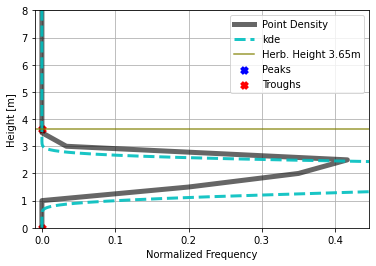

In [60]:
canopyLayerMetrics(h, hbins, plot=True, method='kde', rel_height=1)

({'nlayers': 1,
  'gapsize': 0,
  'maxpeakh': 2.5,
  'ptoh': 0.9803921751955851,
  'cscore': 0.12903225806451613,
  'FHD': 1.1674772126808877,
  'VDR': 0.2458823,
  'VDRpeak': 0,
  'meanpeakh': 2.5,
  'stdpeakh': 0,
  'cvpeakh': 0,
  'herbh': 0.05},
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized Frequency', ylabel='Height [m]'>)

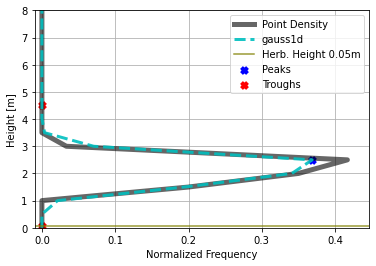

In [65]:
canopyLayerMetrics(h, hbins, plot=True, method='gauss1d', smoothsigma=0.5, rel_height=1)

({'nlayers': 1,
  'gapsize': 0,
  'maxpeakh': 2.0,
  'ptoh': 0.784313740156468,
  'cscore': 0.12903225806451613,
  'FHD': 1.1639149187621525,
  'VDR': 0.2458823,
  'VDRpeak': 0,
  'meanpeakh': 2.0,
  'stdpeakh': 0,
  'cvpeakh': 0,
  'herbh': 0.05},
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized Frequency', ylabel='Height [m]'>)

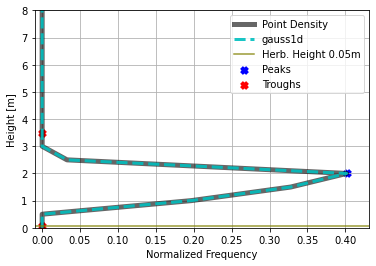

In [66]:
canopyLayerMetrics_cover(c, h, plot=True, method='gauss1d', smoothsigma=0.2, rel_height=1)

In [2]:
# Make a height array for testing
hmax = 10
step = 0.5
groundthres = 0.05
hmin=0
smoothsigma=2

# make a random array of height values from 2 gaussians
h1 = np.abs(np.random.normal(loc=5, scale=1, size=20))
h2 = np.abs(np.random.normal(loc=0.5, scale=0.25, size=20))
# Combine them - this is your test height array
h = np.append(h1, h2)
h = np.append(h, [0,0,0])

(array([19.,  4.,  0.,  0.,  0.,  1.,  3.,  6.,  5.,  5.]),
 array([0.        , 0.65768869, 1.31537737, 1.97306606, 2.63075475,
        3.28844344, 3.94613212, 4.60382081, 5.2615095 , 5.91919818,
        6.57688687]),
 <BarContainer object of 10 artists>)

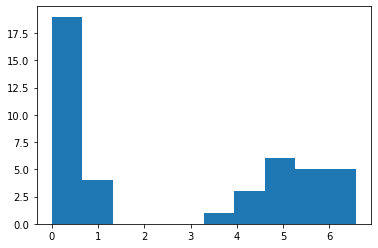

In [3]:
plt.hist(h)

In [4]:
# Where h is an array of point height values
# hbins is a list/array of height bin edges
# smoothsigma = positive float - gives a smoothing parameter for gaussian smoothing in layer calculation (in meters)
# plot = True/False - whether to plot the results

smooths = {}
for s in [0.1, 0.5, 1, 1.5, 2, 2.5]:
    
    # If there are any heights in the array
    # edited 10/26 - have to have at least 2 points above the groundthreshold to do complexity stats
    # This means that a plot with only 1 point will have all metrics automatically set to 0 or nan
    if np.array(h).size >= 2:

        # Calc Cover for height bins
        nbins = ((hmax - hmin) / step) + 1
        hbins = np.linspace(hmin, hmax, int(nbins))

        # IMPORTANT: Using groundthres, you may want to account for errors in relative accuracy
        # EX: IF the rel. accuracy of ground is about 0.06 m (6 cm) between flightlines,
        # the lowest height bin could be set to 0.06 (instead of 0) to account for this.
        # so any hit below 0.06 m counts as ground.
        # NOTE: If you want to use everything, just set groundthres to 0
        if groundthres > 0:
            # insert the groundthres into the array (right above 0)
            heightbins = np.insert(hbins, 1, groundthres)
            # heightbins[heightbins==0] = groundthres
        if groundthres < 0:
            # insert the groundthres into the array (right below 0)
            heightbins = np.insert(hbins, 0, groundthres)
            # heightbins[heightbins==0] = groundthres

        # sort points by height
        h = np.sort(h)

        # Group each point by height bin
        hgroups = np.digitize(h, bins=hbins)

        # Count the number of points in each bin
        # Note: minlength allows it to go to the full length of hbins, rather than stop at the max height of the points
        hcounts = np.bincount(hgroups, minlength=len(hbins))

        # Normalize the counts
        hcounts_norm = hcounts/np.sum(hcounts)

        # Smooth point height distribution, and find peaks and troughs\
        # Following the below article on stack exchange
        # https://stackoverflow.com/questions/62537703/how-to-find-inflection-point-in-python

        # smooth with gaussian filter
        smooths[s] = gaussian_filter1d(hcounts_norm, s)


In [305]:
from scipy.interpolate import UnivariateSpline, CubicSpline, BSpline, splrep, splev, sproot
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

# len(np.arange(hmin, hmax + 0.5, 0.5))
nbins_spline = (((hmax + step*2) - (hmin - step*2)) / step) + 1
hbins_spline = np.linspace((hmin - step*2),(hmax + step*2), int(nbins_spline))

hcounts_norm_spline = np.insert(hcounts_norm, 0, [0,0])
hcounts_norm_spline = np.append(hcounts_norm_spline, [0,0])
hbins_spline, hcounts_norm_spline

K = 2
# bspline = BSpline(hbins_spline, hcounts_norm_spline, k=K, extrapolate=False)
# bspline_smooth = BSpline(hbins_spline, hcounts_norm_spline, k=K, extrapolate=False)
# bspline = BSpline(hbins, hcounts_norm, k=K, extrapolate=False)
# cubicspline = CubicSpline(hbins, hcounts_norm, extrapolate=False)
# unispline = UnivariateSpline(hbins, hcounts_norm)


# gausskde = gaussian_kde([hbins, hcounts_norm], bw_method='scott')

In [68]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

hbins_interp= np.arange(np.min(hbins), np.max(hbins), 0.01)

gausskde = gaussian_kde(h, bw_method='scott')
gausskde_interp = gausskde.pdf(hbins_interp)

idx_peaks, meta = find_peaks(gausskde_interp)
los = []
his = []

# Get the widths of the peak and identify the troughs using a relative heiht value
# rel_height = 0.5 is the full width half max
# rel_height = 1 is the bottom of the gaussian
w, width_heights, left_ips, right_ips = peak_widths(gausskde_interp, idx_peaks, rel_height=1)

# NOTE: convert widths back to height values using the below function
# copied exactly from: https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

widths = index_to_xdata(hbins_interp, w)
left_ips = index_to_xdata(hbins_interp, left_ips)
right_ips = index_to_xdata(hbins_interp, right_ips)

troughs = np.append(left_ips, right_ips)
peaks = hbins_interp[idx_peaks]

In [93]:
left_ips, right_ips

(array([0.  , 2.87]), array([0.78542989, 7.16617929]))

In [56]:
peaks, troughs

(array([0.39, 5.27]), array([0.        , 2.87      , 0.78542989, 7.16617929]))

In [71]:
h, gausskde(h)

(array([0.        , 0.        , 0.        , 0.05018541, 0.05323036,
        0.11282954, 0.23403284, 0.29452149, 0.3278607 , 0.34040452,
        0.3435373 , 0.38659086, 0.40310932, 0.40316812, 0.41465506,
        0.44528733, 0.49144614, 0.51418608, 0.56212229, 0.68873555,
        0.78742186, 0.84959075, 1.21167574, 3.36731458, 4.22597383,
        4.24872845, 4.60218544, 4.83005585, 4.83379484, 4.85977491,
        4.90340863, 4.9632918 , 5.04237979, 5.26307876, 5.35626744,
        5.41603812, 5.6501634 , 5.80468264, 6.12967709, 6.38207227,
        6.42855058, 6.57516069, 6.57688687]),
 array([0.16510912, 0.16510912, 0.16510912, 0.1670847 , 0.16719648,
        0.16919347, 0.17209783, 0.17294891, 0.17324473, 0.17332402,
        0.17334108, 0.17346487, 0.17345758, 0.1734575 , 0.17343446,
        0.17330147, 0.17290541, 0.17262446, 0.17184879, 0.1686376 ,
        0.16502836, 0.16229489, 0.14072214, 0.06389697, 0.09927715,
        0.10026701, 0.11404484, 0.1205549 , 0.12064204, 0.12122868,
  

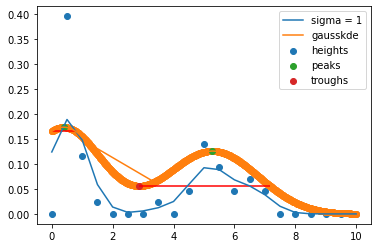

In [58]:
fig, ax= plt.subplots()

hbins_interp= np.arange(hmin, hmax, 0.01)
ax.scatter(hbins, hcounts_norm, label='heights')
# for s in smooths.keys():
for s in [1]:
    ax.plot(hbins, smooths[s], label=f'sigma = {s}')
ax.plot(h, gausskde.evaluate(h), label='gausskde')
ax.scatter(hbins_interp, gausskde.pdf(hbins_interp))
ax.scatter(hbins_interp[idx_peaks], gausskde.evaluate(hbins_interp)[idx_peaks], label='peaks')
ax.scatter(hbins_interp[idx_troughs], gausskde.evaluate(hbins_interp)[idx_troughs], label='troughs')
ax.hlines(width_heights, left_ips, right_ips, color='r')
plt.legend()

In [49]:
# find inflection points
# when it switches from positive to negative (a trough)
idx_troughs = np.where(np.diff(np.sign(np.gradient(gausskde_interp)))>0)[0]
# when it switches from negative to positive (a peak)
idx_peaks = np.where(np.diff(np.sign(np.gradient(gausskde_interp)))<0)[0]

# output height values of peaks and troughs
troughs = hbins_interp[idx_troughs]
peaks = hbins_interp[idx_peaks]

In [50]:
troughs

array([2.87])

In [48]:
peaks, troughs

(array([ 39, 527]), array([0.        , 2.87      , 0.78542989, 7.16617929]))

In [37]:
widths, left_ips

(array([0.78542989, 4.29617929]), array([0.  , 2.87]))

In [491]:
# NOTE: convert widths back to height values using the below function
# copied exactly from: https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

x = hbins_interp
w, width_heights, left_ips, right_ips = peak_widths(gausskde_interp, peaks, rel_height=0.75)

widths = index_to_xdata(x, w)
left_ips = index_to_xdata(x, left_ips)
right_ips = index_to_xdata(x, right_ips)

In [492]:
left_ips, right_ips, widths

(array([0.07328199, 3.74089339]),
 array([0.99544953, 6.67340547]),
 array([0.92216753, 2.93251207]))

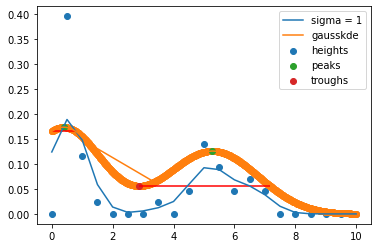

In [43]:
fig, ax= plt.subplots()

hbins_interp= np.arange(hmin, hmax, 0.01)
ax.scatter(hbins, hcounts_norm, label='heights')
# for s in smooths.keys():
for s in [1]:
    ax.plot(hbins, smooths[s], label=f'sigma = {s}')
ax.plot(h, gausskde.evaluate(h), label='gausskde')
ax.scatter(hbins_interp, gausskde.pdf(hbins_interp))
ax.scatter(hbins_interp[idx_peaks], gausskde.evaluate(hbins_interp)[idx_peaks], label='peaks')
ax.scatter(hbins_interp[idx_troughs], gausskde.evaluate(hbins_interp)[idx_troughs], label='troughs')
ax.hlines(width_heights, left_ips, right_ips, color='r')
# ax.plot(bspline_xy[0], bspline_xy[1],label='bspline')
# ax.plot(hbins_interp, bspline(hbins_interp), label='bspline')
# ax.plot(hbins_interp, cubicspline(hbins_interp), label='cubic')
# ax.plot(hbins_interp, unispline(hbins_interp), label='uni')
plt.legend()

In [ ]:
# test out cubic and univar spline 
tx_spline = UnivariateSpline(hbins, np.abs(np.gradient(tc['CoverD2'])), k=5)
tx_cubic = CubicSpline(hbins, np.abs(np.gradient(tc['CoverD2'])))
tx_cubic_1d = tx_cubic.derivative()
tx_cubic_2d = tx_cubic_1d.derivative()

hbins_interp = np.arange(0, np.max(hbins), 0.2)
tx_interp = np.interp(x=hbins_interp, xp=hbins[1:], fp=tc['CoverD2byH'])
tx_1d = np.gradient(tx_interp)
tx_2d = np.gradient(tx_1d)
infls = np.where(np.diff(np.sign(tx_1d)))[0]

In [44]:
bspline_xy[1]

array([-3.06611501e-18,  2.07149785e-01,  4.60700430e-01, -8.68839790e-02,
        2.37315877e-02, -8.04237200e-03,  8.43790027e-03, -2.57092291e-02,
        9.43990160e-02,  9.81131651e-02,  1.13148324e-01,  4.92935408e-02,
        1.39677513e-01, -8.00359335e-03,  4.23368603e-02, -1.13438477e-02,
        3.03853064e-03, -8.10274838e-04,  5.40183225e-04, -2.70091613e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

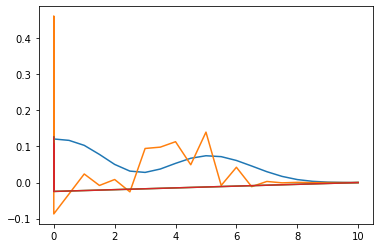